<a href="https://colab.research.google.com/github/jooalee64/mastertip/blob/main/mastip_correct_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

from google.colab import drive
drive.mount('/gdrive')

import os, glob, csv, math, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:

ROOT_DIR = "/gdrive/MyDrive/boats"
IMG_DIR = os.path.join(ROOT_DIR, "yolo/images")
CSV_DIR = os.path.join(ROOT_DIR, "yolo/labels-storage/stage-b-labels")

HULL_CSV = {
    "train": os.path.join(CSV_DIR, "hull-labels", "hull-train.csv"),
    "val": os.path.join(CSV_DIR, "hull-labels", "hull-val.csv"),
    "test": os.path.join(CSV_DIR, "hull-labels", "hull-test.csv")
}
TIP_CSV = {
    "train": os.path.join(CSV_DIR, "tip-labels", "train-tips-csv.csv"),
    "val": os.path.join(CSV_DIR, "tip-labels", "val-tips-csv.csv"),
    "test": os.path.join(CSV_DIR, "tip-labels", "test-tips-csv.csv")
}

IMG_SUBDIRS = {s: os.path.join(IMG_DIR, s) for s in ["train", "val", "test"]}

MAX_SIDE = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def load_yolo_csv(path):
    out = {}
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        base = os.path.splitext(os.path.basename(row['image_name']))[0]
        cx, cy, w, h = float(row['bbox_x']), float(row['bbox_y']), float(row['bbox_width']), float(row['bbox_height'])
        out.setdefault(base, []).append([cx, cy, w, h])
    return out

In [29]:
class MastTipCSVDataset(Dataset):
    def __init__(self, image_dir, hull_csv, tip_csv):
        self.image_dir = image_dir
        self.hulls = self._load_hull_csv(hull_csv)
        self.tips = self._load_tip_csv(tip_csv)
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

    def __len__(self): return len(self.image_paths)

    def _load_hull_csv(self, path):
        out = {}
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            base = os.path.splitext(os.path.basename(row['image_name']))[0]
            # Coordinates are already in pixel space relative to original image
            cx, cy, w, h = float(row['bbox_x']), float(row['bbox_y']), float(row['bbox_width']), float(row['bbox_height'])
            out.setdefault(base, []).append([cx, cy, w, h])
        return out

    def _load_tip_csv(self, path):
        out = {}
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            base = os.path.splitext(os.path.basename(row['image_name']))[0]
            # Coordinates are already in pixel space relative to original image
            cx, cy = float(row['tip_x']), float(row['tip_y'])
            out.setdefault(base, []).append([cx, cy])
        return out


    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        orig_W, orig_H = img.size
        base = os.path.splitext(os.path.basename(path))[0]

        scale = min(MAX_SIDE / orig_W, MAX_SIDE / orig_H)
        new_W, new_H = int(orig_W * scale), int(orig_H * scale)
        img_resized = img.resize((new_W, new_H), Image.BILINEAR)
        canvas = Image.new("RGB", (MAX_SIDE, MAX_SIDE), (114, 114, 114))
        pad_x, pad_y = (MAX_SIDE - new_W) // 2, (MAX_SIDE - new_H) // 2
        canvas.paste(img_resized, (pad_x, pad_y))

        # --- Debug visualization (keep commented unless needed) ---
        # plt.imshow(canvas)
        # plt.title(f"Canvas Image - {base}")
        # plt.axis("off")
        # plt.show()
        # ---------------------------------------------------------


        def to_xyxy(c, scale, pad_x, pad_y):
            # Input c is [cx, cy, w, h] in original pixel coordinates
            cx, cy, w, h = c
            x1 = cx * scale + pad_x
            y1 = cy * scale + pad_y
            x2 = (cx + w) * scale + pad_x
            y2 = (cy + h) * scale + pad_y
            return [x1, y1, x2, y2]

        def to_xy(c, scale, pad_x, pad_y):
            # Input c is [cx, cy] in original pixel coordinates
            cx, cy = c
            return [cx * scale + pad_x, cy * scale + pad_y]

        # Apply the corrected transformation
        hull_boxes = [to_xyxy(c, scale, pad_x, pad_y) for c in self.hulls.get(base, [])]
        tip_points = [to_xy(c, scale, pad_x, pad_y) for c in self.tips.get(base, [])]


        return {
            "image": TF.to_tensor(canvas),
            "hulls": torch.tensor(hull_boxes, dtype=torch.float32),
            "tips": torch.tensor(tip_points, dtype=torch.float32),
            "img_path": path
        }

In [30]:
train_ds = MastTipCSVDataset(IMG_SUBDIRS["train"], HULL_CSV["train"], TIP_CSV["train"])
val_ds   = MastTipCSVDataset(IMG_SUBDIRS["val"], HULL_CSV["val"], TIP_CSV["val"])
test_ds  = MastTipCSVDataset(IMG_SUBDIRS["test"], HULL_CSV["test"], TIP_CSV["test"])

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 1050, Val: 225, Test: 225


In [31]:
import pandas as pd

# Assuming the error is in loading the hull CSV for the train dataset
# Let's inspect the columns of the hull-train.csv file
try:
    df_hull_train = pd.read_csv(HULL_CSV["train"])
    print("Columns in hull-train.csv:")
    print(df_hull_train.columns)
except FileNotFoundError:
    print(f"Error: File not found at {HULL_CSV['train']}")

# Assuming the error might also be in the tip CSV
# Let's also inspect the columns of the train-tips-csv.csv file
try:
    df_tip_train = pd.read_csv(TIP_CSV["train"])
    print("\nColumns in train-tips-csv.csv:")
    print(df_tip_train.columns)
except FileNotFoundError:
    print(f"Error: File not found at {TIP_CSV['train']}")

Columns in hull-train.csv:
Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height'],
      dtype='object')

Columns in train-tips-csv.csv:
Index(['tip_label', 'tip_x', 'tip_y', 'image_name', 'image_width',
       'image_height'],
      dtype='object')


In [32]:

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Sample from train_ds:")
sample = train_ds[0]
print("Image shape:", sample["image"].shape)
print("Hull boxes:", sample["hulls"])
print("Tip points:", sample["tips"])


Sample from train_ds:
Image shape: torch.Size([3, 1024, 1024])
Hull boxes: tensor([[ 91.5963, 499.4587, 258.3486, 520.5963]])
Tip points: tensor([[185.5413, 281.0367]])


In [33]:
import torchvision.models as models
from torchvision.ops import roi_align

class TipNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        layers = list(backbone.children())[:-2]  # remove avgpool & fc
        self.backbone = nn.Sequential(*layers)
        # roi_align expects boxes in the format [batch_index, x1, y1, x2, y2]
        self.roi_align = lambda feats, boxes: roi_align(feats, boxes, output_size=(7,7), spatial_scale=1/32, aligned=True)
        self.tip_head = nn.Sequential(
            nn.Conv2d(512, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x, roi_boxes):
        feats = self.backbone(x)
        rois = []
        for i, boxes in enumerate(roi_boxes):
            for box in boxes:
                rois.append(torch.cat([torch.tensor([i], device=x.device, dtype=torch.float32), box])) # Ensure batch index is float32
        rois = torch.stack(rois)
        pooled = self.roi_align(feats, rois) # Pass the entire rois tensor
        out = self.tip_head(pooled)
        return out

In [34]:
from tqdm import tqdm
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = len(loader)

    for batch in tqdm(loader, desc="Training", leave=False):
        imgs = batch["image"].to(device, non_blocking=True)
        tips = batch["tips"].to(device, non_blocking=True)
        hulls = batch["hulls"].to(device, non_blocking=True)

        optimizer.zero_grad()

        try:
            pred = model(imgs, hulls)
            if pred is None:
                continue  # skip if model skipped empty RoI
            loss = F.mse_loss(pred, tips.view(-1, 2))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except Exception as e:
            print(f"⚠️ Skipping batch due to error: {e}")
            continue

    return total_loss / num_batches


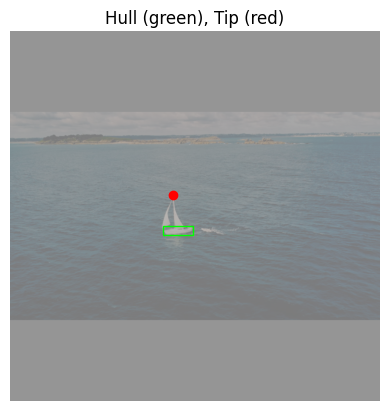

In [35]:

import matplotlib.pyplot as plt

def visualize_sample(sample):
    img = sample["image"].permute(1,2,0).numpy()
    img = (img * 0.229 + 0.485)  # reverse normalization approx
    plt.imshow(np.clip(img, 0, 1))
    for box in sample["hulls"]:
        x1, y1, x2, y2 = box.numpy()
        plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor="lime", fill=False))
    for pt in sample["tips"]:
        plt.plot(pt[0], pt[1], "ro")
    plt.title("Hull (green), Tip (red)")
    plt.axis("off")
    plt.show()

visualize_sample(test_ds[0])


In [13]:
import matplotlib.pyplot as plt
import cv2

@torch.no_grad()
def run_inference(model, dataset, idx=0, device="cuda"):
    model.eval()
    sample = dataset[idx]
    image = sample["image"].unsqueeze(0).to(device)
    hulls = sample["hulls"].unsqueeze(0).to(device)  # [1, N, 4]

    pred_tip = model(image, hulls)[0].cpu().numpy()  # shape (2,)

    # RoI 영역에서 pixel 좌표 복원
    hull_box = sample["hulls"][0].numpy()  # [x1, y1, x2, y2]
    roi_x1, roi_y1, roi_x2, roi_y2 = hull_box
    roi_w = roi_x2 - roi_x1
    roi_h = roi_y2 - roi_y1
    px = pred_tip[0] / 27 * roi_w + roi_x1
    py = pred_tip[1] / 27 * roi_h + roi_y1

    # visuzliation
    img = sample["image"].permute(1,2,0).numpy()
    img = (img * 0.229 + 0.485).clip(0, 1)

    plt.imshow(img)
    x1, y1, x2, y2 = hull_box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='lime', fill=False, linewidth=2))
    plt.plot(px, py, 'ro')  # red dot (predicted mast tip)
    plt.title("Hull box (green), Predicted mast tip (red dot)")
    plt.axis("off")
    plt.show()


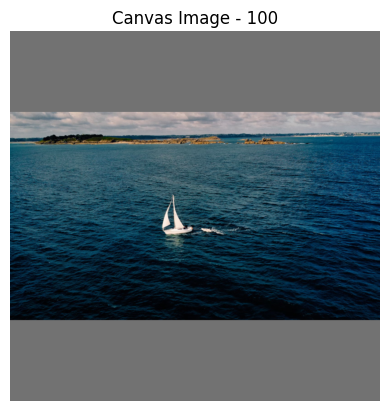

Ground Truth Tip Coordinates (canvas system): (737280.0, 210464.0)


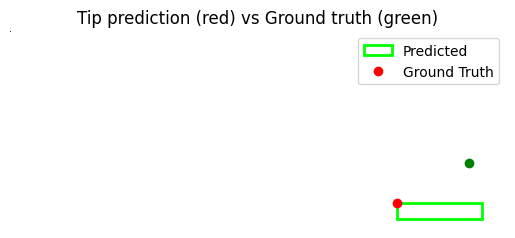

In [28]:
def visualize_gt_and_prediction(sample, pred_tip_feat):
    img = sample["image"].permute(1,2,0).numpy()
    # Removed approximate reverse normalization: img = (img * 0.229 + 0.485).clip(0, 1)
    # Removed redundant clip(0, 1): img = img.clip(0, 1)

    plt.imshow(img)
    x1, y1, x2, y2 = sample["hulls"][0].numpy()
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='lime', fill=False, linewidth=2))

    # predicted tip
    px = pred_tip_feat[0] / 27 * (x2 - x1) + x1
    py = pred_tip_feat[1] / 27 * (y2 - y1) + y1
    plt.plot(px, py, 'ro')

    # ground truth tip
    gx, gy = sample["tips"][0].numpy()
    print(f"Ground Truth Tip Coordinates (canvas system): ({gx}, {gy})") # Debug print
    plt.plot(gx, gy, 'go')  # green dot

    plt.legend(["Predicted", "Ground Truth"])
    plt.axis("off")
    plt.title("Tip prediction (red) vs Ground truth (green)")
    plt.show()


# Initialize the model and load trained weights (assuming the previous training cell was run)
# If you are running this cell without running the training cell first in a new session,
# you would need to load saved weights here.
model = TipNet().to(DEVICE)

# Get a sample from the test dataset (you can change the index)
sample_idx = 0
sample = test_ds[sample_idx]

# Move the image and hull data to the device the model is on
image = sample["image"].unsqueeze(0).to(DEVICE)
hulls = sample["hulls"].unsqueeze(0).to(DEVICE)

# Get the predicted tip features from the trained model
# Ensure the model is in evaluation mode
model.eval()
with torch.no_grad():
    pred_tip_feat = model(image, hulls)[0].cpu().numpy()

# Visualize the ground truth and prediction
visualize_gt_and_prediction(sample, pred_tip_feat)

In [15]:
@torch.no_grad()
def evaluate_model(model, dataset, device="cuda"):
    model.eval()
    nme_list = []
    for sample in dataset:
        img = sample["image"].unsqueeze(0).to(device)
        hulls = sample["hulls"].unsqueeze(0).to(device)
        tip_gt = sample["tips"][0].numpy()  # (2,)
        pred = model(img, hulls)[0].cpu().numpy()  # (2,)

        # 복원 (RoI → pixel)
        box = sample["hulls"][0].numpy()
        roi_x1, roi_y1, roi_x2, roi_y2 = box
        w, h = roi_x2 - roi_x1, roi_y2 - roi_y1

        pred_x = pred[0] / 27 * w + roi_x1
        pred_y = pred[1] / 27 * h + roi_y1
        gt_x = tip_gt[0]
        gt_y = tip_gt[1]

        dist = np.linalg.norm([pred_x - gt_x, pred_y - gt_y])
        img_diag = np.sqrt(sample["image"].shape[1]**2 + sample["image"].shape[2]**2)
        nme = dist / img_diag
        nme_list.append(nme)

    mean_nme = np.mean(nme_list)
    print(f"Mean NME: {mean_nme:.4f}")
